In [1]:
# Standard modules needed
import numpy as np
import pandas as pd
import datetime as dt
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
from scipy.optimize import minimize
from scipy import interpolate
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches

In [2]:
# You may need these packages
#!conda install -c conda-forge statsmodels
#!pip install seaborn
#!pip install openpyxl

# Problem 1: Windmill industry in Denmark

This exercise deals with the power generated by windmills in Denmark. As windmills are considered an important element in the transition to a zero emission economy we should take a closer look at the electricity production stemming from them.

To this end, you need to download the official data set containing all windmills in Denmark which produced by the Danish Energy Agency. You can download it using the module `requests` and then save it as the xlsx file `windmills.xlsx`. This is done in the cell below.   


In [3]:
import requests

url = "https://ens.dk/sites/ens.dk/files/Statistik/anlaeg.xlsx"
r = requests.get(url)

with open('windmills.xlsx', 'wb') as xls_file:
    xls_file.write(r.content)    


*Note: `requests` is in the Anaconda distribution, so it should be available to you. If it is not, install it by running `python -m pip install requests` in your terminal.*    

By inspecting `windmills.xlsx` you'll see it has two sheets: 1) `IkkeAfmeldte-Existing turbines` which holds mills (turbines) currently in use and 2) `Afmeldte-Decommissioned` which are no longer in service. Throughout the rest of the exercise, you need to use data from both of them.


### Question 1

1. Load the two sheets of `windmills.xlsx` into your notebook and combine them into one pandas DataFrame. Note that you need to do some data cleaning in the process. For instance, you can disregard the variables which are not present in both sheets. You can decide for yourself whether you want to use English or Danish column names.  

First we clean the data and combine two sheets of the windmills.xlsx

In [4]:
pd.set_option('display.max_columns',200) # I want to see all the columns
pd.set_option('display.max_rows',735) 

In [5]:
#downloading both excel sheet
ex = pd.ExcelFile('windmills.xlsx')
ex1 = pd.read_excel(ex, 'IkkeAfmeldte-Existing turbines', skiprows=7)
ex2 = pd.read_excel(ex, 'Afmeldte-Decommissioned', skiprows=7)

In [6]:
#The shape of the files
print(ex1.shape)
print(ex2.shape)

(6309, 63)
(3455, 64)


In [7]:
#list of indicers we want to drop
dr = []
for i in range(2,10):
    dr.append(i)

In [8]:
# Dropping rows
ex1.drop(index=dr, inplace=True)
ex1.reset_index(inplace = True, drop = True) 
ex1.loc[1,'Historic production figures (kWh):':'Unnamed: 62'] = ex1.loc[0,'Historic production figures (kWh):':'Unnamed: 62']
ex1.columns = ex1.iloc[1,:]
ex1.drop(index=[0,1], inplace=True)

In [9]:
# Dropping rows
ex2.drop(index=dr, inplace=True)
ex2.reset_index(inplace = True, drop = True) # Drop old index too
ex2.loc[1,'Historic production figures (kWh):':'Unnamed: 63'] = ex2.loc[0,'Historic production figures (kWh):':'Unnamed: 63']
ex2.columns = ex2.iloc[1,:]
ex2.drop(index=[0,1,3446], inplace=True)

In [10]:
diff_var = [y for y in ex1.columns.unique() if y not in ex2.columns.unique()] 
print(f'Variables in ex1 sheet, but not in ex2: {diff_var}')

Variables in ex1 sheet, but not in ex2: ['Manufacture', 'Model', 'Local authority no', 'Local authority\nname']


In [11]:
# We drop those variables which are not in both sheets
ex1.drop(columns=diff_var,inplace = True) 

In [12]:
# Combine two files into one
fin = pd.concat([ex2, ex1])
fin.reset_index(inplace = True, drop = True) 

2. Plot the development in total electricity production from windmills between 1977-2021. You may use GWh (1 million KWh) as unit. 


We divede KWh by 1,000,000 in order to get GWh 

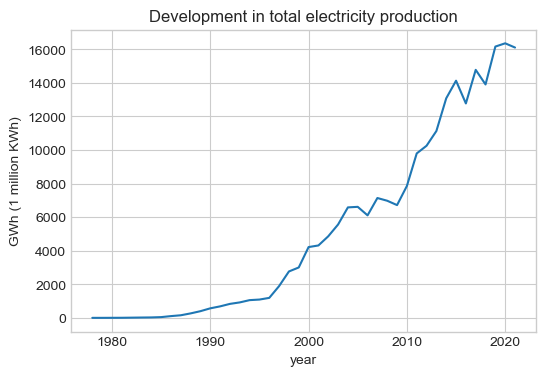

In [13]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('GWh (1 million KWh)')
ax.set_xlabel('year')
plt.title('Development in total electricity production')
ax.plot(fin.loc[9742,1978:2021] / 1000000);

### Question 2

We now want to know how the capacity of electricity production has changed over the years. For this we need two variables `Date of original connection to grid` and `Capacity (kW)`. The first indicates when a mill was initiated and the other its production capacity. 
1. Calculate and plot the development in **average**  and  **maximum** capacity of turbines based on their year of initialization (1977-2021)  
    **Note:** capacity is measured in KW, so you need to multiply with the number of hours pr year to make it comparable with annual production. 
2. To get a cleaner view of the trends, compute and plot the 7 year moving average of annual mean capacity and annual max capacity.   

    $\text{ma}^7(x_t) = \frac{x_{t-3}+x_{t-2}+...+x_{t}+...+x_{t+3}}{7}$
3. Finally, compute the **total capacity** of all windmills in Denmark in each year. Plot total capacity together with actual production as calculated in Question 1.  
    **Note:** the capacity of a turbine should only be included for the years when it is connected to the grid.   

In [14]:
fin_2 = fin.copy()

fin_2['date'] = fin_2.loc[:,'Date of original connection to grid']
fin_2['date2'] = fin_2.loc[:,'Date of decommissioning']

fin_2['date'] = pd.to_datetime(fin_2['date'],format='%Y%m%d')
fin_2['year'] = pd.DatetimeIndex(fin_2['date']).year

fin_2['date2'] = pd.to_datetime(fin_2['date2'],format='%Y%m%d')
fin_2['year2'] = pd.DatetimeIndex(fin_2['date2']).year

In [15]:
# Capacity multiplyed by amount of hours in a year
fin_2['cap_in_gwh'] = fin_2['Capacity (kW)'] * 8765.81277/1000000

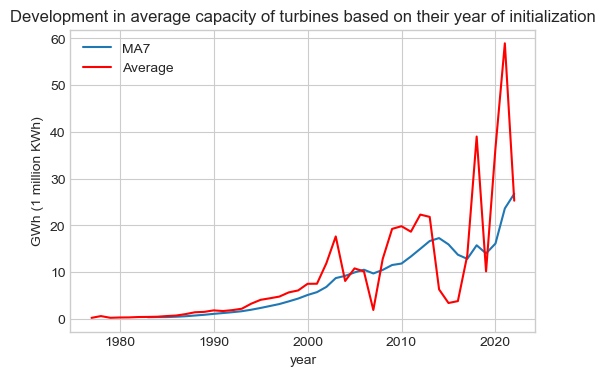

In [16]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('year')
ax.set_ylabel('GWh (1 million KWh)')
plt.title('Development in average capacity of turbines based on their year of initialization')
ax.plot(fin_2.groupby(['year'])['cap_in_gwh'].mean().rolling(7).mean(), label='MA7')
ax.plot(fin_2.groupby(['year'])['cap_in_gwh'].mean(), color='r', label='Average')
ax.legend();

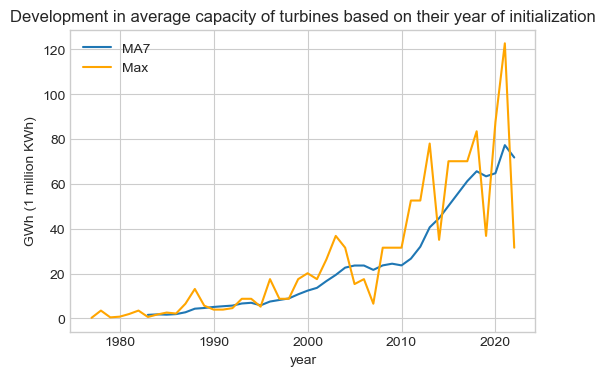

In [17]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('year')
ax.set_ylabel('GWh (1 million KWh)')
plt.title('Development in average capacity of turbines based on their year of initialization')
ax.plot(fin_2.groupby(['year'])['cap_in_gwh'].max().rolling(7).mean(), label='MA7')
ax.plot(fin_2.groupby(['year'])['cap_in_gwh'].max(), color='orange', label='Max')
ax.legend();

In [18]:
three = fin_2.loc[:,['Capacity (kW)','year','year2']]
three['year2'] = three['year2'].replace(np.nan, 2022) #2022 instead of NaN

In [20]:
cap = []
for i in fin_2.loc[:,1977:2021].columns:
    cap.append(three[(three['year'] <= i) & (three['year2'] >= i)]['Capacity (kW)'].sum())

In [21]:
cap_h = []
for i in cap:
    cap_h.append(i * 8765.81277/1000000)

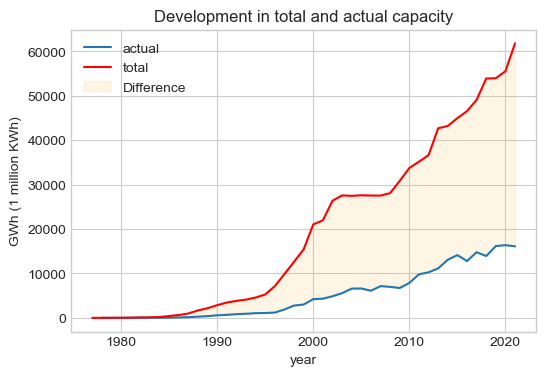

In [41]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('GWh (1 million KWh)')
ax.set_xlabel('year')
plt.title('Development in total and actual capacity')
ax.plot(fin.loc[9742,1978:2021]/1000000, label='actual')
ax.plot(fin_2.loc[:,1977:2021].columns.tolist(), cap_h, color ='r',label='total')
ax.fill_between(fin_2.loc[:,1977:2021].columns.tolist(),(fin.loc[9742,1977:2021]/1000000).tolist(), cap_h ,color="orange", alpha=0.2,label='Difference')
plt.legend();

The total capacity of all windmills in Denmark is a way bigger than actual, which make sense. 
Wind power isn't always strong enough. Some days windmills could be disconected from the grid due to service or reparetaions.

### Question 3

There is a lot of debate about the visual impact on the landscape from windmills. This exercise deals with the relationship between windmill size and productivity to get a sense of the tradeoff. You can solve it in many different ways depending on your preferences. The important thing is that the results are clear. 

1. Compute and plot the relationship between height of windmills and their electricity production in 2021. The variable `Hub height (m)` indicates the height of a mill in meters. One possible approach is to discretize the height variable and compute the median electricity production within each bin. But you can also apply a statistical model of your own choosing.
2. Repeat the method you chose above, but now group over the type of location as well. Locations are described by the variable `Type of location` and can be either *off-shore* ("HAV") or *on-shore* ("LAND","Land"). When plotting the results, use common limits on the y-axis for better comparison.  
4. Finally, we dig into the productivity of on-shore vs. off-shore mills.   
Compute and plot the *average difference* between annual capacity and annual production for mills on-shore and mills off-shore in each year 1990-2021. 

In [90]:
opg3 = fin.copy()
opg31 = opg3.loc[:, ['Hub height (m)', 2021]].dropna()
opg31.rename(columns = {'Hub height (m)': 'height',2021 : 'y2021'}, inplace=True)
opg31['height'] = opg31['height'].astype(float)

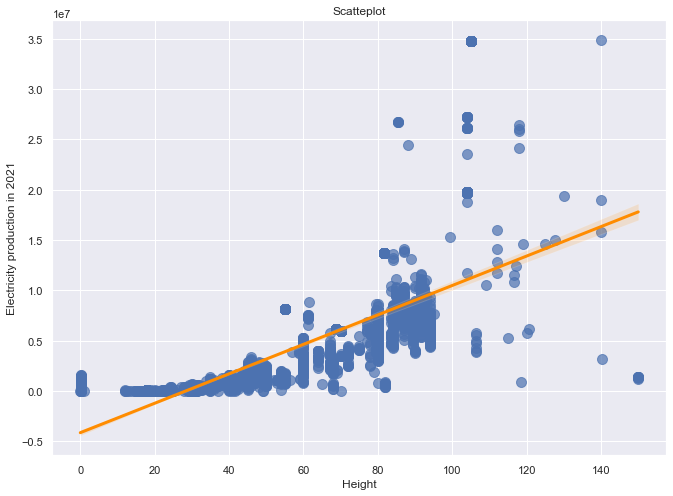

In [91]:
sns.set(rc={'figure.figsize':(11,8)})
sns.regplot(x=opg31['height'].astype(float),y=opg31['y2021'],
            line_kws={'lw': 3, 'color': 'darkorange'},
            scatter_kws={'s': 100, 'alpha': 0.7}); 
plt.xlabel('Height')
plt.ylabel('Electricity production in 2021')
plt.title('Scatteplot');

We can see clear possitive relationship between hight of mill and electricity production

In [92]:
OLS = smf.ols(formula='y2021 ~ height', data=opg31).fit() 
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  y2021   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     7609.
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        12:41:05   Log-Likelihood:            -1.0340e+05
No. Observations:                6306   AIC:                         2.068e+05
Df Residuals:                    6304   BIC:                         2.068e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.131e+06   8.66e+04    -47.723      0.0

In [93]:
opg31['types'] = opg3.loc[:,'Type of location'].str.lower()

In [94]:
I = opg31.types == 'land'
Ii = opg31.types == 'hav'
opg31_l = opg31[I]
opg31_h = opg31[Ii]
print(opg31_l.shape)
print(opg31_h.shape)

(5676, 3)
(630, 3)


For on-shore only

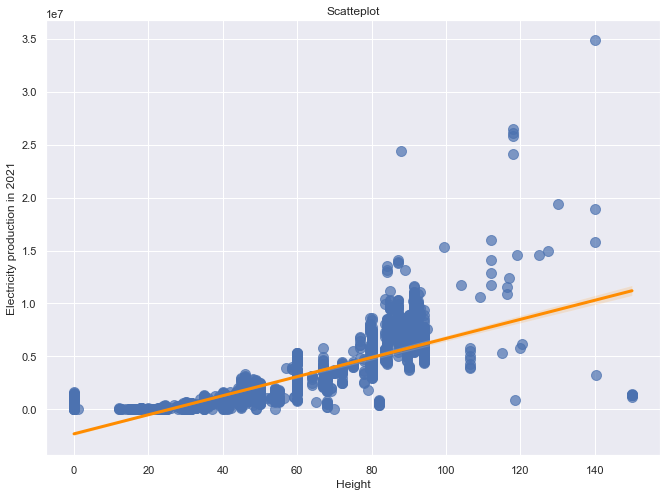

In [95]:
sns.set(rc={'figure.figsize':(11,8)})
sns.regplot(x=opg31_l['height'].astype(float),y=opg31_l['y2021'],
            line_kws={'lw': 3, 'color': 'darkorange'},
           scatter_kws={'s': 100, 'alpha': 0.7}); 
plt.xlabel('Height')
plt.ylabel('Electricity production in 2021')
plt.title('Scatteplot');

In [96]:
OLS = smf.ols(formula='y2021 ~ height', data=opg31_l).fit() 
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  y2021   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                 1.217e+04
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        12:41:05   Log-Likelihood:                -88206.
No. Observations:                5676   AIC:                         1.764e+05
Df Residuals:                    5674   BIC:                         1.764e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -2.3e+06   3.89e+04    -59.182      0.0

For off-shore only

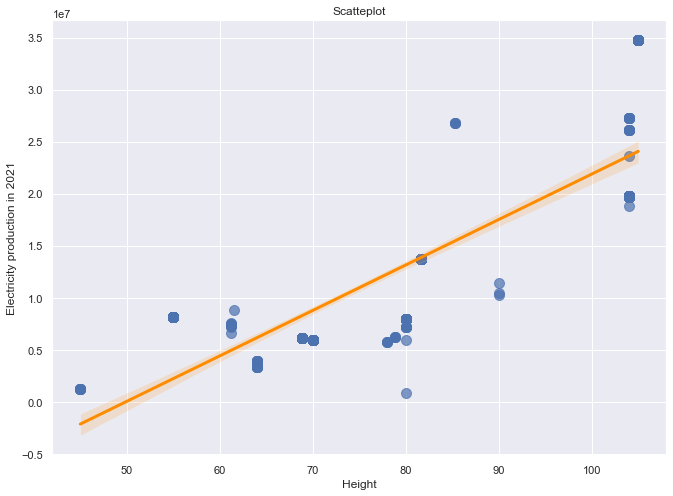

In [97]:
sns.set(rc={'figure.figsize':(11,8)})
sns.regplot(x=opg31_h['height'].astype(float),y=opg31_h['y2021'],
            line_kws={'lw': 3, 'color': 'darkorange'},
           scatter_kws={'s': 100, 'alpha': 0.7}); 
plt.xlabel('Height')
plt.ylabel('Electricity production in 2021')
plt.title('Scatteplot');

In [98]:
OLS = smf.ols(formula='y2021 ~ height', data=opg31_h).fit() 
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  y2021   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     1312.
Date:                Thu, 26 May 2022   Prob (F-statistic):          5.65e-156
Time:                        12:41:05   Log-Likelihood:                -10595.
No. Observations:                 630   AIC:                         2.119e+04
Df Residuals:                     628   BIC:                         2.120e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.181e+07   9.55e+05    -22.844      0.0

We can see that most of mill are located on-shore. There are 'only' 630 mills located off-shore.
We can conclude that there is much greater possitive relationship for off-shore mills, which makes sens.

In [99]:
fin_2['types']= fin_2.loc[:,'Type of location'].str.lower()
fin_2['year2'] = fin_2['year2'].replace(np.nan, 2022)
I = fin_2.types == 'land'
Ii = fin_2.types == 'hav'
fin_2_l = fin_2[I]
fin_2_h = fin_2[Ii]

In [100]:
on = fin_2_l.groupby(['year'])['Capacity (kW)'].mean()
off = fin_2_h.groupby(['year'])['Capacity (kW)'].mean()
on = on[1991:2021]

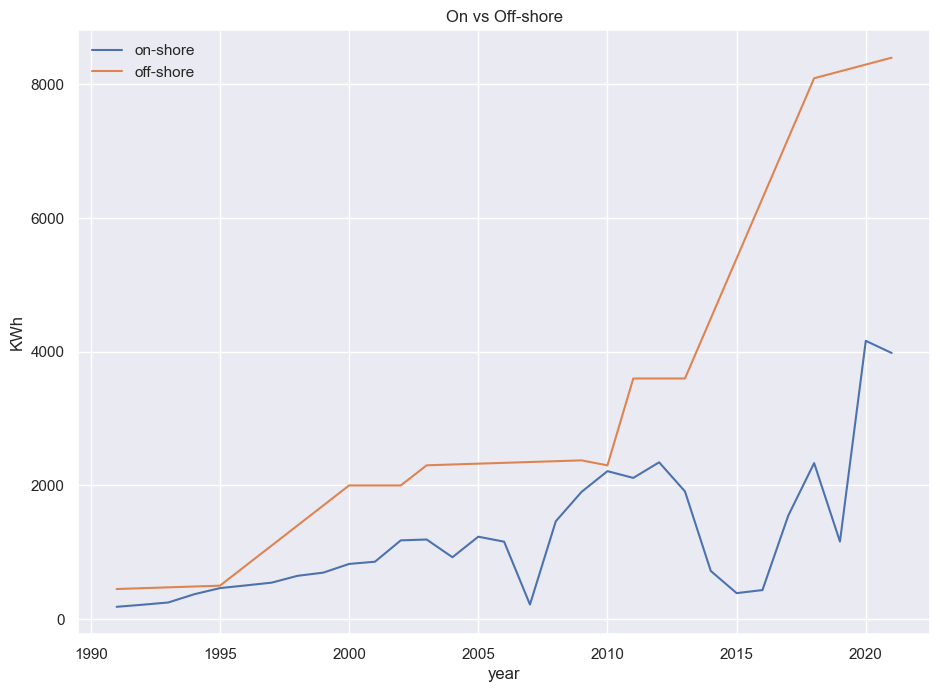

In [101]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('KWh')
ax.set_xlabel('year')
plt.title('On vs Off-shore')
ax.plot( on, label='on-shore')
ax.plot(off, label='off-shore')
plt.legend();

Off-shore mills are much stronger

# Problem 2: A discrete-continuous consumption-saving model

Here we will consider a modification to the 2-period consumption saving model.   
In addition to making a consumption-saving choice in the first period, there is now also a binary choice of whether or not to attend costly education. Taking an education is in this model associated with higher expected earnings in period 2 but it comes at a monetary cost in period 1.   

**Second period**  
Household gets utility from **consuming** and **leaving a bequest**:

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

**First period**   
Household gets utility from consuming. It takes into account that if choosing to go to school today, expected income will be higher in second period.

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1,s}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
s& = \begin{cases} 
1 & \text{if study in period 1} \\
0 & \text{otherwise}
\end{cases}\\
a_1&=m_1-c_1-\tau s\\
m_2&= (1+r)a_1+y_2 \\
y_{2}&= \begin{cases}
\bar{y} + \gamma s +\Delta & \text{with prob. }p\\
\bar{y} + \gamma s -\Delta & \text{with prob. }1-p 
\end{cases}\\
a_1&\geq0
\end{aligned}
$$

* $s$ is a binary indicator for whether the agent chooses to study in period 1.  
* $c$ is consumption
* $\gamma$ is the income premium associated with having studied 
* $\tau$ is the monetary cost of studying, paid in period 1
* $m$ is cash-on-hand  
* $a$ is end-of-period assets
* $\bar{y}$ is base income in period 2
* $y_2$ is total realized income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving if $p = 0.5$)
* $r$ is the interest rate
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $a\geq0$ ensures the household *cannot* borrow

**Hint:** the study choice is discrete (and thus not differentiable) which means that it cannot be optimized for in the same manner as the continuous consumption choice. Therefore, you need to solve the consumption problem *for each* of the two study choices and pick the **combination** of studying and consuming that yields highest value as the model solution.  

In [102]:
import exam as ex

In [103]:
# Parameters
rho = 8.0
nu = 0.1
kappa = 1  
beta = 0.90

tau = 0.8
gamma = 1.2
ybar = 1.5
r = 0.04
p = 0.5
Delta = 0.4

m_min = tau+1e-5    # minimum value for m - must be possible to pay for studying
m_max = 5.0         # maximum value for m


### Question 1  
1. Solve the model for the parameters above. 
2. Plot $v_1(m_1)$ and $v_2(m_2)$. Comment.
3. Plot the optimal consumption function $c_1^{*}(m_1)$ and $c_2^{*}(m_2)$ in one graph. Comment on the shapes of the functions.
4. Plot the optimal study choice function $\mathbb{I}^{s*}(m_1)$. Comment on the shape of the function.

Firstly, we do as in lecture 11, where we define both utility- and bequest functions. This leads to a definition of v in period 2: \begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\end{aligned} 

Our aim of this subquistion is to solve the model for the given parameters. To do this, we start by introducing our parameters which is devided in preferences, return & income and grids.

By solving the model, we will be able to plot both value- and consumption functions.

In [104]:
par = SimpleNamespace()

# preferences
par.rho = 8.0
par.nu = 0.1
par.kappa = 1
par.beta = 0.90

# return and income
par.tau = 0.8
par.gamma = 1.2
par.ybar = 1.5
par.r = 0.04
par.p = 0.5
par.Delta = 0.4
par.s = 0

# grid
par.Nm = 500 # number of grid points for m
par.m_min = par.tau+1e-5 # minimum value for m
par.m_max = 5.0 # maximum value for m

The minimum cash-on-hand value, m, is given as $$\tau+1e-5$$ which equals 0.80001.

From here we solve for both period 2 and 1, called "last periode" and "single period", respectively. (This is mostly done in the exam.py-file).

In [105]:
m2_grid,v2_func,c2_func = ex.solve_last_period(par)
v2_func_interp = interpolate.RegularGridInterpolator([m2_grid],v2_func,bounds_error=False,fill_value=None)

Both grids and functions are divided into periods 1 and 2.

The division made in the .py file makes it possible to compare the value function of period 1, if the student has chosen the monitery cost, s = 1 or not, s = 0. 

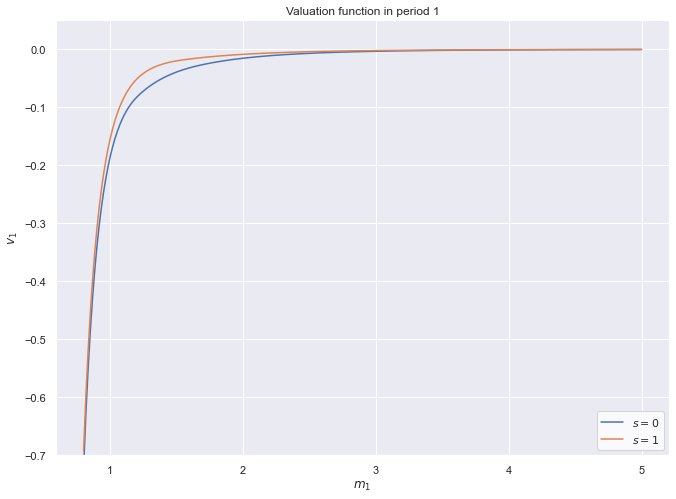

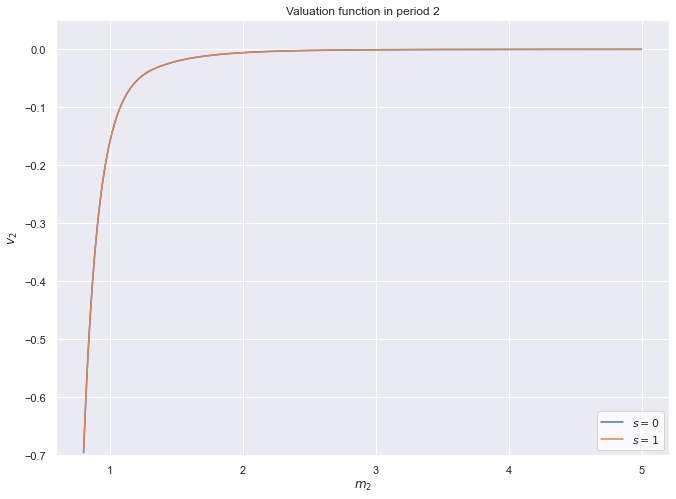

In [106]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

_s = par.s
for s in [0, 1]:
    par.s = s
    m1_grid,c1_func,m2_grid,c2_func,v1_func,v2_func = ex.solve(par)
    ax.plot(m1_grid,v1_func,label=f'$s = {s}$')
    par.s = _s # reset
    
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$')
ax.set_title('Valuation function in period 1')
ax.set_ylim([-0.7,0.05]);

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

_s = par.s
for s in [0, 1]:
    par.s = s
    m1_grid,c1_func,m2_grid,c2_func,v1_func,v2_func = ex.solve(par)
    ax.plot(m1_grid,v2_func,label=f'$s = {s}$')
    par.s = _s # reset
    
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('Valuation function in period 2')
ax.set_ylim([-0.7,0.05]);

From the plot there is a clear difference in period 1, but none i period 2. If the household has cash-in-hand, m_1, between approximately 0.6 and approximately 2.6, there is a significantly larger value choosing to study in period 1. 

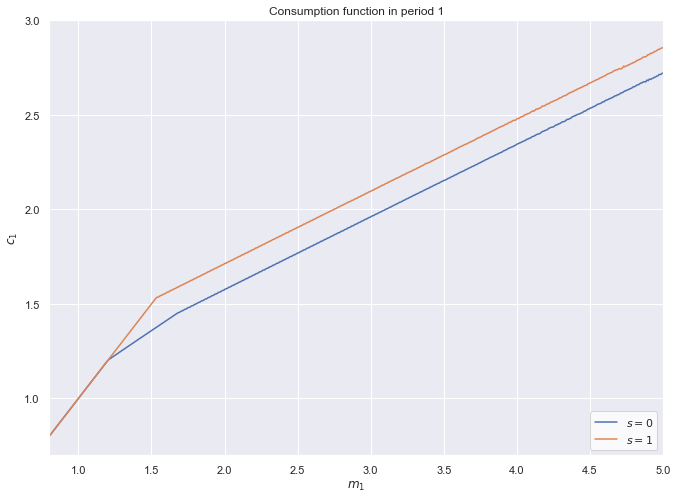

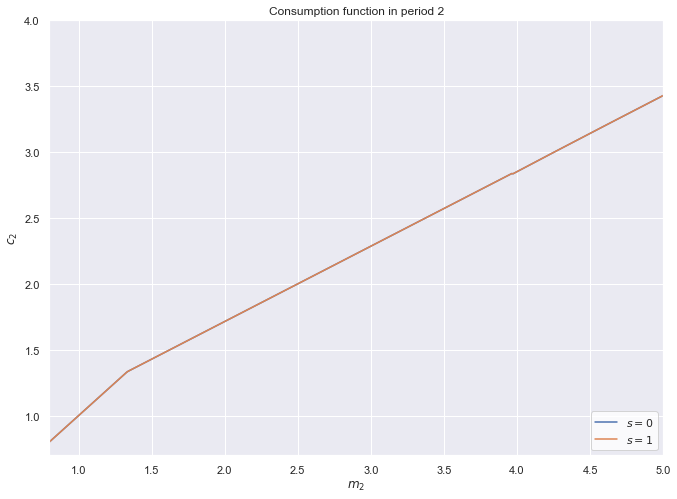

In [107]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

_s = par.s
for s in [0, 1]:
    par.s = s
    m1_grid,c1_func,m2_grid,c2_func,v1_func,v2_func = ex.solve(par)
    ax.plot(m1_grid,c1_func,label=f'$s = {s}$')
    par.s = _s # reset
    
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('Consumption function in period 1')
ax.set_xlim([par.m_min,5])
ax.set_ylim([0.7,3]);

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

_s = par.s
for s in [0, 1]:
    par.s = s
    m1_grid,c1_func,m2_grid,c2_func,v1_func,v2_func = ex.solve(par)
    ax.plot(m2_grid,c2_func,label=f'$s = {s}$')
    par.s = _s # reset
    
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('Consumption function in period 2')
ax.set_xlim([par.m_min,5])
ax.set_ylim([0.7,4]);

From our two consumption functions of period 1, we see that the consumption keeps increasing in the beginning for s = 1, but slows down to the same level of choosing not to study. For period 2 they match each-other, as the value functions did. 

To check for the optimal study choice, we compare the numeric results of s = 0 and s = 1. We know that the plot will be either linear at 0 or 1, due to the discrete binary distribution. Thus, the plot may vary at a given point, and maybe start in 0, then move to 1 and back to zero.

In [108]:
results = []
_s = par.s
for s in [0, 1]:
    par.s = s
    m1_grid,c1_func,m2_grid,c2_func,v1_func,v2_func = ex.solve(par)
    res = v1_func
    results.append(res)
    par.s = _s # reset
results_2 = []
for i in range(0,len(results[0])):
    if results[0][i] <= results[1][i]:
        results_2.append(1)

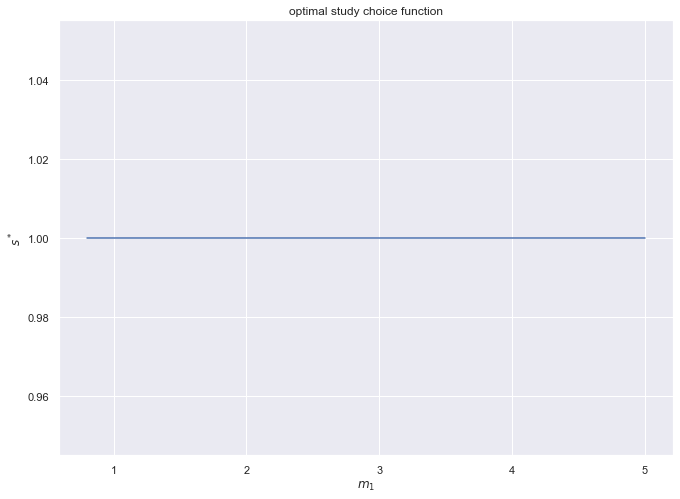

In [109]:
plt.plot(m1_grid, results_2)
plt.title('optimal study choice function')
plt.xlabel('$m_1$')
plt.ylabel('$s^*$')
plt.show()

We see that it is always at least as profitable for the household to study than not. Within the m_min and m_max, s = 1 >= s = 0.


### Question 2  
1. Given the wage premium on education, compute the **smallest** education cost $\tau$ such that an agent with $m_1 = 3.0$ will **no longer** choose to study.  
    **Hint**: there are different ways of obtaining that number. A bisection algorithm is one possibility. 


# Approximating a function

In this exercise, you will implement an algorithm to approximate a function $f(x)$ if $x$ is on the interval $[-1,1]$.  

A degree $N$ approximation of $f(x)$ takes the general form 
$$
\hat{f}(x) = \sum_{i=1}^{N} a_i T_i(x)
$$

for which you need 3 elements: 
1. the functions $T_i(x)$  
2. $M$ evaluation nodes $\{z_k\}$.
3. $N$ coefficients $\{a_i\}$  

**1.**  
The functions $T_i(x)$ take the form 
$$
T_i(x) = \cos(i\times\arccos(x))
$$ 
**2.**  
The true function $f$ needs to be evaluated on a set of nodes so that we can use these function evaluations for our approximation. The set of nodes where $f$ is evaluated, $\{z_k\}$, has to be chosen wisely such that the approximation error is minimized.  
It turns out to be on the form 
$$
z_k = -cos(\frac{2k-1}{2M}\pi), \:\:\:\: k=1,2,3,\dots,M
$$ 
**3.**  
The $N$ coefficients of the approximation are obtained by what is essentially a least squares regression. They are on the form
$$
a_i = \frac{\sum_{k=1}^M f(z_k) T_i(z_k)}{\sum_{k=1}^M T_i(z_k)^2}, \:\:\:\: i=1,2,3,\dots,N
$$ 
**Notes:**  in general one can let $N<M$.   
Observe that we are using $M$ evaluations of $f(z)$ to create **each** of the $N$ approximation coefficients. This can be done up front and needs only to be done once even if you need to approximate $f$ on multiple $x$'s. This is why such an approximation is useful in the context of solving an economic model. For instance, a value function may be very computationally intensive, so you'll benefit from only having to to evaluate it $M$ times in order to get, say, $K>>M$ function approximations.    

### Question 1 

Create an approximator $\hat{f}(x)$ at an $x\in[-1,1]$ by implementing the following algorithm:

1. For each $k=1,...,M$: compute $z_k = -cos(\frac{2k-1}{2M}\pi)$
2. For each $k=1,...,M$: compute $y_k = f(z_k)$
3. For each $i=1,...,N$: compute $a_i = \frac{\sum_{k=1}^M y_k T_i(z_k)}{\sum_{k=1}^M T_i(z_k)^2}$
4. Return $\sum_{i=1}^{N} a_i T_i(x)$

**Note:** you can use the numpy functions `np.arccos` in $T_i$ and `np.cos` in $z_k$. 
The code below defines the function that returns $\hat{f}(x)=\sum_{i=1}^N a_iT_i(x)$. First we define the space for $k\in M$ which $z_k=-\cos\left(\frac{2k-1}{2M}\cdot\pi\right)$ (here noted by z) and $y_k=f(z_k)$ (here noted by y) iterates over, and then the space for $i \in N$ which $a_i=\frac{\sum_{k=1}^{M}y_kT_i(z_k)}{\sum_{k=1}^{M}T_i(z_k)^2}$ (here noted by a) iterates over. Then the functions z, y, a are defined, which for each $k$, and $i$, returns the values according to the formulas written in the latter. Lastly we define a for loop which returns the sum of every $a_i\cdot\cos[i\cdot \arccos(x)]$.

In [110]:
def f_approx(x, f, N, M):
    
    k = np.linspace(1, M, M)
    i = np.linspace(0, N, N)
    
    z = lambda k: -np.cos(((2*k-1) / (2*M)) * np.pi)
    y = lambda z: f(z)
    a = lambda i: sum(y(z(k))*np.cos(i*np.arccos(z(k)))) / sum(np.cos(i*np.arccos(z(k)))**2)
    
    sum_list = []
    for item in i:
        sum_list.append(a(item) * np.cos(item*np.arccos(x)))
        
    return sum(sum_list)

### Question 2 


Evaluate `f_approx` at $x \in \{-0.5, 0.0, 0.98\}$ and report in each case also the deviation from the true value `f(x)`. 

Given the following $f$-function and parameters:

In [111]:
f = lambda x: 1/(1+x**2) + x**3 - 0.5*x
M = 8
N = 5
xs = np.array([-0.5, 0.0, 0.98])

The code below evalueates both $\hat{f}(x)$ and $f(x)$ for each $x$ in $xs$ given a specified $f$-function and parameters stated above:

In [112]:
approximation_vals = []
for x in xs:
    approximation_vals.append(f_approx(x, f, N, M))
    
true_vals = []
for x in xs:
    true_vals.append(f(x))
    
deviation = list(np.array(true_vals) - np.array(approximation_vals))

We find the output of the true function to be:

In [113]:
true_vals

[0.925, 1.0, 0.9612919795960007]

We find the output of the approximation function to be:

In [114]:
approximation_vals

[0.8018145790845369, 0.789864293773255, 0.7863681930608226]

Subtracting the outputs of the functions yields the approximations error:

In [115]:
deviation

[0.12318542091546314, 0.21013570622674504, 0.17492378653517804]

We find that the approximation function performs fairly well, as the approximation errors aren't to high. However the approximation might be optimized choosing other settings of $N$ and $M$. 

Below the two functions are plotted for different values of $x\in[-1;1]$

In [116]:
store_vals_true = []
store_vals_approx = []
for x in np.linspace(-1,1,500):
    store_vals_true.append(f(x))
    store_vals_approx.append((f_approx(x,f,N,M)))

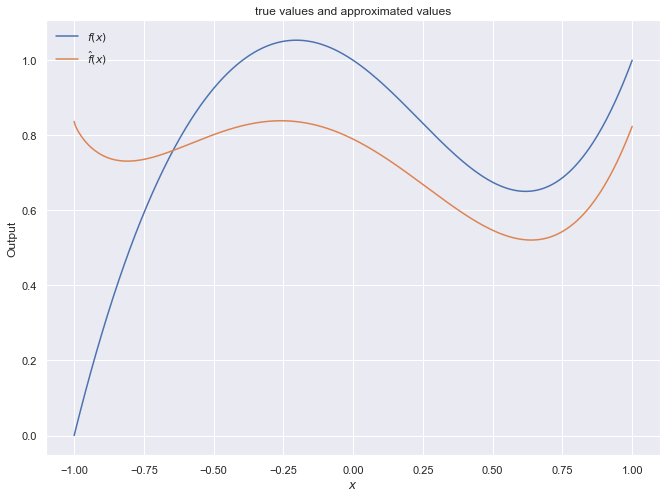

In [117]:
plt.plot(np.linspace(-1,1,500), store_vals_true, label='$f(x)$')
plt.plot(np.linspace(-1,1,500), store_vals_approx, label='$\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('Output')
plt.title('true values and approximated values')
plt.legend()
plt.show()